# Subsample Document Experiment

This notebook is designed to follow up on the decrease in token overlap between abstracts across the years. The hypothesis is that the small fraction of tokens shared across the years is due to the small number of available documents. To test theory documents posted in the years that have a high count are subsampled to be equal to the number of documents in the early most year (2000). After subsampling, the tokens are compared to see if the fraction of tokens shared changes.

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
import csv
from datetime import datetime
import itertools
from pathlib import Path
import pickle

import lxml.etree as ET
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from biovectors_modules.word2vec_run_helper import (
    PubMedSentencesIterator,
    PubtatorTarIterator,
    chunks,
)

# Load the Data

In [2]:
pickle_file = "output/unique_tokens_by_year_replace.pkl"
tokens_by_year = pickle.load(open(pickle_file, "rb"))

# Compare Number of Tokens

## Equal Number of Tokens for each YEar

In [3]:
data_rows = []
reversed_tokens = list(sorted(tokens_by_year.keys()))[::-1]
all_tokens = set(tokens_by_year[2020].keys())

for query_year in reversed_tokens[2:22]:
    np.random.seed(100)
    avail_tokens = list(tokens_by_year[query_year].keys())
    if len(avail_tokens) > len(all_tokens):
        avail_tokens = set(
            np.random.choice(avail_tokens, len(all_tokens), replace=False)
        )
        total_tokens = all_tokens
    else:
        total_tokens = set(
            np.random.choice(list(all_tokens), len(avail_tokens), replace=False)
        )

    query_year_vocab_set = set(avail_tokens)
    tokens_matched = total_tokens & query_year_vocab_set

    data_rows.append(
        {
            "years": str(query_year) if query_year != 2020 else "2020",
            "percentage_tokens_mapped": len(tokens_matched) / len(total_tokens),
            "num_tokens_matched": len(tokens_matched),
            "num_tokens_total": len(total_tokens),
        }
    )

In [4]:
token_overlap_df = pd.DataFrame.from_dict(data_rows)
token_overlap_df

,years,percentage_tokens_mapped,num_tokens_matched,num_tokens_total
0,2019,0.362154,205083,566286
1,2018,0.376278,213081,566286
2,2017,0.381459,216015,566286
3,2016,0.395007,223687,566286
4,2015,0.405168,229441,566286
5,2014,0.394507,209433,530873
6,2013,0.366697,171041,466437
7,2012,0.339261,142017,418607
8,2011,0.315867,119056,376918
9,2010,0.288721,94638,327784


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/subsampled_tokens_overlap.png


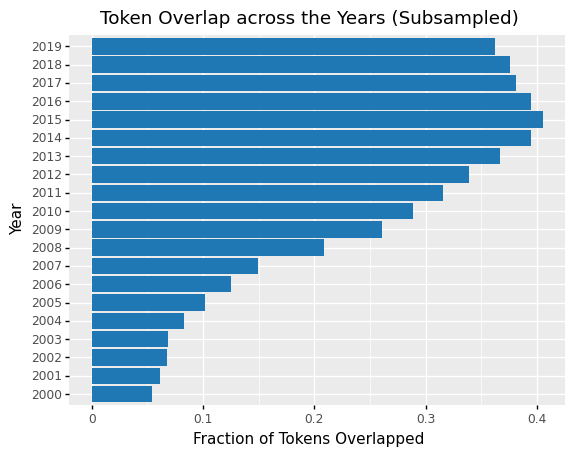

In [5]:
g = (
    p9.ggplot(
        token_overlap_df,
        p9.aes(x="years", y="percentage_tokens_mapped"),
    )
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Token Overlap across the Years (Subsampled)",
        x="Year",
        y="Fraction of Tokens Overlapped",
    )
)
g.save("output/figures/subsampled_tokens_overlap.png", dpi=500)
print(g)

## Equal number of tokens across each Year

In [14]:
data_rows = []
reversed_tokens = list(sorted(tokens_by_year.keys()))[::-1]
np.random.seed(100)
all_tokens = np.random.choice(
    sorted(list(set(tokens_by_year[2020].keys()))), len(set(tokens_by_year[2000]))
)
all_tokens = set(all_tokens)

for query_year in reversed_tokens[2:22]:
    avail_tokens = list(tokens_by_year[query_year].keys())
    query_year_vocab_set = set(avail_tokens)
    tokens_matched = all_tokens & query_year_vocab_set

    data_rows.append(
        {
            "years": str(query_year) if query_year != 2020 else "2020",
            "percentage_tokens_mapped": len(tokens_matched) / len(total_tokens),
            "num_tokens_matched": len(tokens_matched),
            "num_tokens_total": len(total_tokens),
        }
    )

In [15]:
equal_token_overlap_df = pd.DataFrame.from_dict(data_rows)
equal_token_overlap_df

,years,percentage_tokens_mapped,num_tokens_matched,num_tokens_total
0,2019,0.477761,17025,35635
1,2018,0.461933,16461,35635
2,2017,0.449053,16002,35635
3,2016,0.429606,15309,35635
4,2015,0.413330,14729,35635
5,2014,0.393265,14014,35635
6,2013,0.363996,12971,35635
7,2012,0.335709,11963,35635
8,2011,0.311772,11110,35635
9,2010,0.283373,10098,35635


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/subsampled_tokens_overlap.png


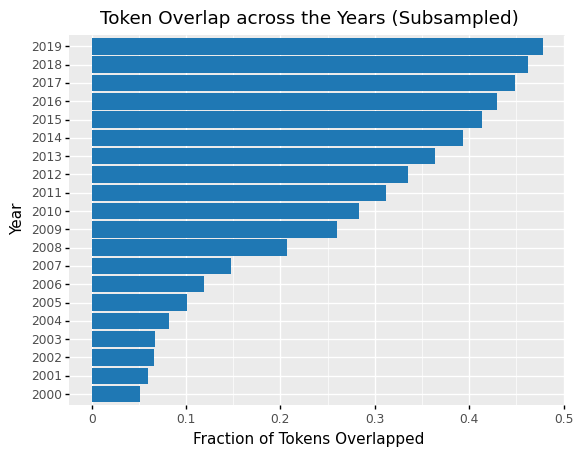

In [16]:
g = (
    p9.ggplot(
        equal_token_overlap_df,
        p9.aes(x="years", y="percentage_tokens_mapped"),
    )
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Token Overlap across the Years (Subsampled)",
        x="Year",
        y="Fraction of Tokens Overlapped",
    )
)
g.save("output/figures/subsampled_tokens_overlap.png", dpi=500)
print(g)

# Conclusions

1. The small number of mismatches appear to be the result of not using a lemmatizer along with general changes in scientific publications overtime.
2. Numbers could improve if I were to correct for the issues mentioned above; however, the overall message here is that earlier years have a bias that I nee